In [214]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [215]:
class CubicBezier:
    def __init__(self, p0, p1, p2, p3):
        self.points = [p0, p1, p2, p3]
    
    def calc(self, t):
        T = [
            t * t * t,
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 3, 0, 0],
            [1, 0, 0, 0]
        ])
        return T @ coeffs @ self.points
    
    def d(self, t):
        T = [
            t * t,
            t,
            1
        ]
        coeffs = np.array([
            [-3, 9, -9, 3],
            [6, -12, 6, 0],
            [-3, 3, 0, 0]
        ])
        return T @ coeffs @ self.points
    
    def d2(self, t):
        T = [
            t,
            1
        ]
        coeffs = np.array([
            [-6, 18, -18, 6],
            [6, -12, 6, 0]
        ])
        return T @ coeffs @ self.points
    
    def curvature(self, t):
        d = self.d(t)
        d2 = self.d2(t)
        return (d[0] * d2[0] - d[1] * d2[1]) / (math.hypot(*d) ** 3)
        

In [216]:
class Constraints:
    def __init__(self, vel, acc, dec, track_width, friction_coeff):
        self.max_vel = vel
        self.max_acc = acc
        self.max_dec = dec
        self.track_width = track_width
        self.friction_coeff = friction_coeff
    
    def max_speed(self, curvature):
        max_turn_speed = 2 * self.max_vel / (2 + abs(curvature) * self.track_width)
        max_slip_speed = math.sqrt(self.friction_coeff / abs(curvature) * 9.81 * 39.3701)
        return min(max_turn_speed, max_slip_speed)

In [217]:
# p0 = [0, 0]
# p1 = [20, -18]
# p2 = [45, -14]
# p3 = [37, 9]

p0 = [0, 0]
p1 = [5, -25]
p2 = [25, -35]
p3 = [70, 0]

# p0 = [0, 0]
# p1 = [30, -20]
# p2 = [50, 20]
# p3 = [70, 0]

# p0 = [0, 0]
# p1 = [30, 0]
# p2 = [50, 0]
# p3 = [70, 0]

# p0 = [0, 0]
# p1 = [50, 0]
# p2 = [50, 0]
# p3 = [50, 50]

# p0 = [0, 0]
# p1 = [50, 0]
# p2 = [0, 50]
# p3 = [50, 50]

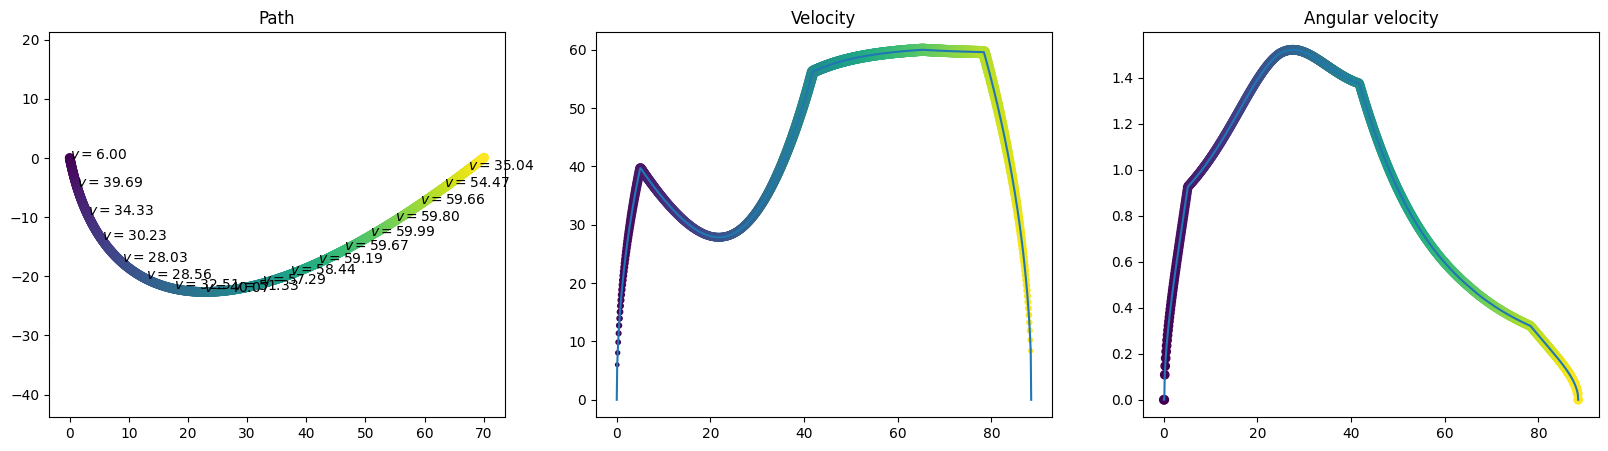

In [218]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

path = CubicBezier(p0, p1, p2, p3)
constraints = Constraints(60, 180, 180, 11, 0.1)

positions = [p0]
vels = [0]
omegas = [0]

v = 0
step = 0.1
dist = step
t = 0
prev_w = 0
i = 0
prev_heading = math.atan2(path.d(0)[1], path.d(0)[0])
while t <= 1:
    d = path.d(t)
    d2 = path.d2(t)
    t += step / math.hypot(*d)
    
    curvature = path.curvature(t) # inefficient, already have d and d2
    # w = v * curvature
    heading = math.atan2(d[1], d[0])
    w = (heading - prev_heading) * (v / step)
    a = (w - prev_w) * (v / step)

    prev_w = w
    prev_heading = heading
    
    max_accel = constraints.max_acc - abs(a * constraints.track_width / 2)

    v = min(constraints.max_speed(curvature), (v**2 + 2 * max_accel * step)**0.5)
    dist += step
    positions.append(path.calc(t))
    vels.append(v)
    omegas.append(w)
    i += 1

vels[i] = 0
vels[i] = 0

v = 0
t = 1
prev_w = 0
prev_heading = math.atan2(path.d(1)[1], path.d(1)[0])
i = len(positions)
while t >= 0:
    d = path.d(t)
    d2 = path.d2(t)
    t -= step / math.hypot(*d)
    
    curvature = path.curvature(t)
    heading = math.atan2(d[1], d[0])
    w = -(heading - prev_heading) * (v / step)
    a = (w - prev_w) * (v / step)
    prev_heading = heading
    prev_w = w
    
    max_accel = constraints.max_dec - abs(a * constraints.track_width / 2)
    v = min(constraints.max_speed(curvature), (v ** 2 + 2 * max_accel * step) ** 0.5)
    dist -= step
    i -= 1
    
    # vels[i] = min(v, vels[i])
    if abs(v) < abs(vels[i]):
        vels[i] = v
    if abs(w) < abs(omegas[i]):
        omegas[i] = w

ax1.axis('equal')
def coords(arr):
    return [i*step for i in range(len(arr))], arr
ax2.plot(*coords(vels))
ax3.plot(*coords(omegas))
cmap = plt.get_cmap('viridis')
ax1.scatter([p[0] for p in positions], [p[1] for p in positions], c=coords(positions)[0], cmap=cmap)
ax2.scatter(*coords(vels), vels, c=coords(vels)[0], cmap=cmap)
ax3.scatter(*coords(omegas), c=coords(omegas)[0], cmap=cmap)
ax1.set_title('Path')
ax2.set_title('Velocity')
ax3.set_title('Angular velocity')
for i in range(len(positions)):
    if i % 50 == 1:
        ax1.annotate(f'$v={vels[i]:.2f}$', positions[i])

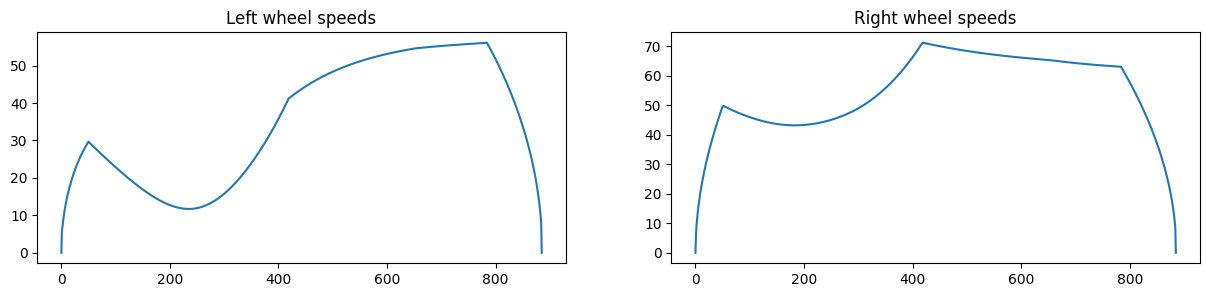

In [219]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

ax1.set_title('Left wheel speeds')
ax2.set_title('Right wheel speeds')

left_wheels = [vels[i] - omegas[i] * constraints.track_width for i in range(len(vels))]
right_wheels = [vels[i] + omegas[i] * constraints.track_width for i in range(len(vels))]

ax1.plot([i for i in range(len(vels))], left_wheels)
ax2.plot([i for i in range(len(vels))], right_wheels)